# Module 1: Introduction to Exploratory Analysis 

## Step 2:  Data Cleaning & Creating New Variables

A big part of exploratory analysis involves data validation. This means gaining an understanding of the distribution of data, any potential data issues that can affect the quality of your model. As we learnt during our theory lesson, " Data preparation accounts for about 80% of the work of data scientists.” [source](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#27df67b36f63).

What does data cleaning look like:

#### 1) Are my variables the right type?

Type is very important in Python programing, because it affects the types of functions you can apply to a series. There are a few different types of data you will see regularly (see [this](https://en.wikibooks.org/wiki/Python_Programming/Data_Types) link for more detail):
* **int** - a number with no decimal places. example: loan_amount field
* **float** - a number with decimal places. example: partner_id field
* **str** - str is short for string. This type formally defined as a sequence of unicode characters. More simply, string means that the data is treated as a word, not a number. example: sector
* **boolean** - can only be True or False. There is not currently an example in the data, but we will be creating a gender field shortly.
* **datetime** - values meant to hold time data. Example: posted_date

#### 2) Is there missing data?

If we have missing data, is the missing data at random or not at random? If data is missing at random, the data distribution is still representative of the population. You can probably ignore the missing values as an inconvienience. However, if the data is missing systematically, any modeling you do may be biased. You should carefully consider the best way to clean the data, it may involve dropping some data. See [here](https://en.wikipedia.org/wiki/Missing_data) for additional information.

#### 3) Sanity check the data, does it match what you expected to find:
- is the range of values what you would expect. For example, are all loan_amounts above 0.
- do you have the number of rows you would expect
- is your data for the date range you would expect. For example, is there a strange year in the data like 1880.
- are there unexpected spikes when you plot the data over time


In this section, we will go over all these steps:

 1)  **Checking variable type**
   
 2)  **Checking for missing variables**
   
 3)  **Number of observations in the dataset**
   
 4)  **Descriptive statistics**

### Import packages

In [22]:
import pandas as pd
import numpy as np
from ggplot import *
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser

# The command below means that the output of multiple commands in a cell will be output at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

### Import dataset

We read in our merged dataset below. Don't forget to update the name with your own! 

In [58]:
data_path = 'C://Users/JANE_DOE/Desktop/intro_course_data_science_for_good/data'
data_path = 'C:/Users/kevin pan/Dropbox/dev/kiva_/input'
df = pd.read_csv(data_path+'/df.csv', low_memory=False)

In the cell below, we take a random sample of 2 rows to get a feel for the data.

In [6]:
df.sample(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
76405,85623,85623,85567,Grocery Store,NaN,True,"[{'first_name': 'Munyazi', 'last_name': '', 'g...",NaN,['en'],"Munyazi lives in a home of her own in Tiribe, ...",NaN,NaN,NaN,475,2013-02-23,530074,1298696,1,0,0,19,475,Kenya,KE,town,1 38,point,Tiribe,Munyazi,164.0,[],2013-03-24,2013-02-22,Food,funded,[],40000.0,KES,2013-02-22T08:00:00Z,475,...,NaN,NaN,NaN,to purchase inventory for the store.,NaN,NaN,NaN,NaN,1,24.3,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.164711,0.085473,NaN,0.000000,NaN,2081417.0,1.0,0.000000,21415.0,Yehu Microfinance Trust,33.1,NaN,2.23,3.5,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2010-03-30T20:50:03Z,active,7646925.0,http://www.yehu.org,2013-02-22 18:10:02,2013-02-23 23:27:33,2013-03-24 18:10:02,2013-02-22 08:00:00,1,2013-02-22,2013,2,1.0
95000,104626,104626,104568,Dairy,NaN,False,"[{'first_name': 'Anonymous', 'last_name': '', ...",NaN,['en'],NaN,NaN,NaN,NaN,725,2011-12-29,370734,726677,1,0,0,25,725,Kenya,KE,country,1 38,point,NaN,Anonymous,156.0,[],NaN,2011-12-15,Agriculture,funded,[],63600.0,KES,2011-11-29T08:00:00Z,725,...,NaN,Sheilah Asher,274296.0,NaN,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2011-12-15 16:30:07,2011-12-29 20:58:20,NaN,2011-11-29 08:00:00,1,2011-11-29,2011,12,14.0


### Are my variables the right type?

Let's check the type of our variables using the examples we saw in the cell above.

In [23]:
type_example = df[['loan_amount','partner_id', 'sector','posted_date']]
type_example.sample(3)

,loan_amount,partner_id,sector,posted_date
48318,725,156.0,Agriculture,2015-01-15
111881,975,133.0,Agriculture,2010-05-05
26613,150,164.0,Food,2016-02-28


We use the panda function `to_datetime`, which converts our format from object to datetime. You can run the `.dtype` command above to verify we have converted successfully. We also want to create a YY-MM variable for each, which will allow us to more easily aggregate our data later in the module.

In [59]:
## Convert to datetimes
df['posted_datetime']             = pd.to_datetime(df['posted_date'])
df['funded_datetime']             = pd.to_datetime(df['funded_date'])
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_date'])
df['dispursal_datetime']          = pd.to_datetime(df['terms.disbursal_date'])
df['number_of_loans']             = 1

## Convert to date
df['posted_date']                 = df['posted_datetime'].dt.date
df['planned_expiration_date']     = df['planned_expiration_datetime'].dt.date
df['funded_date']                 = df['funded_datetime'].dt.date
df['dispersal_date']              = df['dispursal_datetime'].dt.date

## Create additional variables
df['posted_year']                 = df['posted_datetime'].dt.year
df['posted_month']                = df['posted_datetime'].dt.month
df['time_to_fund']                = df['funded_datetime'] - df['posted_datetime']
df['time_to_fund']                = df.time_to_fund.dt.days

We can check if we were successful by checking the type again. 

In [60]:
df['posted_datetime'].head(1)
df['posted_datetime'].dtype

0   2017-05-09
Name: posted_datetime, dtype: datetime64[ns]

dtype('<M8[ns]')

### Do I have missing values?

We want to see how many values are missing in certain variable columns. One way to do this is to count the number of null observations. 

For this, we wrote a short function to apply to the dataframe. 

We print out the first few observations, but you can remove the .head() to print out all columns. 

In [29]:
#Create a new function:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print("Missing values per column:")
print(df.apply(num_missing, axis=0).head(10)) #axis=0 defines that function is to be applied on each column

#Applying per row:
print("\nMissing values per row:")
print(df.apply(num_missing, axis=1).head()) #axis=1 defines that function is to be applied on each row

Missing values per column:
Unnamed: 0                            0
Unnamed: 0.1                          0
Unnamed: 0.1.1                        0
activity                              0
basket_amount                    117372
bonus_credit_eligibility              0
borrowers                             0
currency_exchange_loss_amount    102626
description.languages                 0
description.texts.en               4328
dtype: int64

Missing values per row:
0    15
1    15
2    14
3    15
4    16
dtype: int64


Remember when we used a left join to merge in the partner data. That means we could have null (missing) values in our partner_id field. We check this in the cell below and find that we have 9,642 loans that are missing. Let's investigate and try and understand whether the data is missing at random or systematically missing.

In [25]:
len(df.index) - df['basket_amount'].count()

117372

In [28]:
null_basket_amount = df.loc[df['basket_amount'].isnull()]
len(null_basket_amount)
null_basket_amount.head(2)

117372

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,...,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
16,16,16,16,Primary/secondary school costs,NaN,False,"[{'first_name': 'Sally ', 'last_name': '', 'ge...",NaN,['en'],"Sally is an ambitious woman from Bomet, a maiz...",NaN,NaN,NaN,150,2017-05-09,1291449,2515878,1,0,0,6,150,Kenya,KE,town,1 38,point,Bomet,Sally,156.0,[],2017-06-07,2017-05-08,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}]",15000.0,KES,2017-05-28T07:00:00Z,150,...,NaN,NaN,NaN,to pay school fees for her children.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079.0,1.0,24.200354,18150.0,Juhudi Kilimo,33.0,NaN,-7.10,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925.0,http://www.juhudikilimo.com/,2017-05-08,2017-05-09,2017-06-07,2017-05-28 07:00:00,1,2017-05-28,2017,5,1.0
21,21,21,21,Celebrations,NaN,False,"[{'first_name': 'Naomi', 'last_name': '', 'gen...",NaN,['en'],Naomi is a single mother of 2 children and she...,NaN,NaN,NaN,100,2017-05-08,1291404,2515811,1,0,0,4,100,Kenya,KE,town,1 38,point,nyeri,Naomi,386.0,[],2017-06-07,2017-05-08,Personal Use,funded,"[{'name': '#Animals'}, {'name': '#Parent'}, {'...",10000.0,KES,2017-04-03T07:00:00Z,100,...,NaN,Cheryl Strecker,1412668.0,to buy a goat for a celebration during the Eas...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.000000,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-08,2017-05-08,2017-06-07,2017-04-03 07:00:00,1,2017-04-03,2017,5,0.0


It seems that the number of loans peaked in 2014, and has decreased. All of the loans issued in the second half of 2015, 2016, 2017 have a partner. This tells us these values are not missing at random, they are more likely to occur in data before June 2015, and are most likely to occur in the first half of 2014. We should probably just drop data with the partner_id missing. We do so below using the notnull() function which checks if the field is populated.

In [17]:
df = df.loc[df['partner_id'].notnull()]

As a sanity check that our filtering was correctly done we check the new number of rows. It makes sense!

In [18]:
len(df.index)

118316

In [19]:
df.to_csv('~/intro_course_data_science_for_good/data/df.csv')

### Additional Sanity Checks

**Does the dataset have the number of rows you would expect?**

In the command below we find out the number of loans and number of columns by using the function shape. You can also use len(df.index) to find the number of rows.

In [20]:
print('There are %d observations and %d features' % (df.shape[0],df.shape[1]))

There are 118316 observations and 77 features


This tells us there are 118,316 observations and 84 features. We learnt in the theory lesson that each row is an observation and each column is a potential feature. 118,000 matches with what we expect based upon our conversations with Kiva. This is a very healthy sample size for applying machine learning algorithms.

### Descriptive statistics of the dataset

In Module 1, we learned about mean, frequency and percentiles as a powerful way to understand the distribution of the data. If you are unfamiliar with these terms or need a refresher [this](https://www.mathsisfun.com/data/frequency-grouped-mean-median-mode.html) overview should be helpful. The "describe" command below provides key summary statistics for each numeric column.

In [24]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,basket_amount,currency_exchange_loss_amount,funded_amount,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,partner_id,terms.disbursal_amount,terms.loan_amount,terms.loss_liability.currency_exchange_coverage_rate,terms.repayment_term,translator.image,video.id,video.thumbnailImageId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_total_amount_raised,number_of_loans,posted_year,posted_month,time_to_fund
count,118316.000000,118316.000000,118316.000000,944.000000,15690.000000,118316.000000,1.183160e+05,1.183160e+05,118316.0,118316.0,118316.0,118316.000000,118316.000000,118316.000000,1.183160e+05,118316.000000,114447.000000,118316.000000,6.301700e+04,76.000000,7.600000e+01,118316.000000,118316.000000,118316.000000,118316.000000,0.0,118316.000000,0.0,1.183160e+05,118316.0,118316.000000,118316.000000,111917.000000,0.0,106890.000000,1.183160e+05,118316.0,118316.000000,118316.000000,112704.000000
mean,64433.371843,64433.371843,64398.230239,0.185381,7.017447,473.439771,7.096035e+05,1.540915e+06,1.0,0.0,0.0,14.608227,495.159784,165.037552,4.178579e+04,495.159784,0.122154,13.461079,1.165835e+06,1291.697368,6.155305e+05,1.930686,30.026747,0.212524,3.821426,NaN,4.358150,NaN,1.496709e+06,1.0,11.528738,18174.752434,31.054133,NaN,2.362943,7.309958e+06,1.0,2013.558783,6.424904,8.009858
std,38178.638548,38178.638548,38157.158427,2.145937,15.655207,676.663803,3.412929e+05,6.043467e+05,0.0,0.0,0.0,20.216517,704.079168,66.001909,4.474124e+04,704.079168,0.041529,8.147379,7.036716e+05,1027.999559,4.622450e+05,3.031490,17.099929,0.262458,10.477770,NaN,5.472373,NaN,6.022014e+05,0.0,10.893620,9423.900289,10.444965,NaN,11.299052,3.289116e+06,0.0,2.343340,3.559524,12.372766
min,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,2.510000e+02,4.090000e+02,1.0,0.0,0.0,0.000000,25.000000,6.000000,2.500000e+01,25.000000,0.100000,2.000000,2.392400e+04,150.000000,2.975740e+05,1.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,3.560000e+02,1.0,0.000000,0.000000,0.000000,NaN,-117.790000,0.000000e+00,1.0,2006.000000,1.000000,-441.000000
25%,29578.750000,29578.750000,29564.750000,0.000000,1.220000,250.000000,4.202852e+05,1.013473e+06,1.0,0.0,0.0,7.000000,250.000000,133.000000,2.000000e+04,250.000000,0.100000,11.000000,5.186710e+05,487.750000,3.244948e+05,1.000000,24.300000,0.089354,0.085473,NaN,0.000000,NaN,1.495190e+06,1.0,0.000000,9546.000000,29.000000,NaN,-1.700000,6.764500e+06,1.0,2012.000000,3.000000,0.000000
50%,66559.500000,66559.500000,66517.500000,0.000000,3.490000,350.000000,6.975760e+05,1.575774e+06,1.0,0.0,0.0,11.000000,375.000000,156.000000,3.000000e+04,375.000000,0.100000,14.000000,1.186147e+06,665.500000,3.361080e+05,1.000000,34.900000,0.164711,1.483890,NaN,2.536684,NaN,1.592689e+06,1.0,16.058249,18150.000000,33.100000,NaN,0.000000,7.646925e+06,1.0,2014.000000,6.000000,2.000000
75%,98296.250000,98296.250000,98238.250000,0.000000,8.280000,600.000000,1.003961e+06,2.052755e+06,1.0,0.0,0.0,18.000000,600.000000,164.000000,5.000000e+04,600.000000,0.100000,14.000000,1.668411e+06,2154.250000,6.247900e+05,1.000000,40.100000,0.364948,3.652283,NaN,8.017062,NaN,2.081410e+06,1.0,18.498507,21415.000000,36.000000,NaN,2.230000,8.133425e+06,1.0,2016.000000,10.000000,13.000000
max,127957.000000,127957.000000,127899.000000,25.000000,1285.510000,50000.000000,1.292273e+06,2.516905e+06,1.0,0.0,0.0,1589.000000,50000.000000,526.000000,1.596948e+06,50000.000000,0.200000,122.000000,2.499150e+06,3008.000000,1.754457e+06,46.000000,54.800000,7.513861,94.939083,NaN,100.000000,NaN,2.520600e+06,1.0,100.000000,30794.000000,41.000000,NaN,30.300000,1.136698e+07,1

In order to get the same summary statistics for categorical columns (string) we need to do a little data wrangling. The first line of code filters for all columns that are a data type object. As we know from before this means they are considered to be a string. The final row of code provides summary statistics for these character fields.

In [22]:
categorical = df.dtypes[df.dtypes == "object"].index
df[categorical].describe()

,activity,borrowers,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_date,location.country,location.country_code,...,video.title,video.youtubeId,partner_charges_fees_and_interest,partner_countries,partner_name,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_url
count,118316,118316,118316,113988,3,3,4,112704,118316,118316,...,76,76,118316,118316,118316,118316,113754,118316,118316,114249
unique,149,29987,4,113859,3,3,4,106844,1,1,...,72,74,2,11,52,9,16,52,3,34
top,Farming,"[{'first_name': 'Anonymous', 'last_name': '', ...",['en'],"Hello Kiva Community! <br /><br />Meet Jane, w...","Beatrice is 51 years old, married and supports...",Mwanajuma is a married woman with two children...,Gerald is a married man. He has 2 children. He...,2005-03-31T06:27:55Z,Kenya,KE,...,Kiva Entrepreneur Rose from,6dWFtYShzBk,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",VisionFund Kenya,3.5,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2009-05-29T11:35:11Z,active,http://www.visionfundkenya.co.ke/
freq,26243,2420,118306,5,1,1,1,24,118316,118316,...,2,2,117376,106639,28570,39681,46681,28570,104271,28570


In the table above, there are 4 really useful fields: 

1) **count** - total number of fields populated (Not empty). 

2) **unique** - tells us how many different unique ways this field is populated. For example 4 in description.languages tells us there are 4 different language descriptions. 

3) **top** - tells us the most popular data point. For example, the top activity in this dataset is Farming which tells us most loans are in Farming.

4) **freq** - tells us that how frequent the most popular category is in our dataset. For example, 'en' (english) is the language almost all descriptions (description.languages) are written in (118,306 out of 118,316).

One red flag from the table above is the summary statistics for the field location.geo.pairs. It seems that 77,254 loans come from the same latitude and longitude. Given the granularity of coordinates this seems highly unlikely. Let's investigate further. Below we plot the geo coordinate field.

C:\Users\kevin pan\AppData\Local\Continuum\Anaconda3\lib\site-packages\ggplot\ggplot.py:602: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  fill_levels = self.data[[fillcol_raw, fillcol]].sort(fillcol_raw)[fillcol].unique()


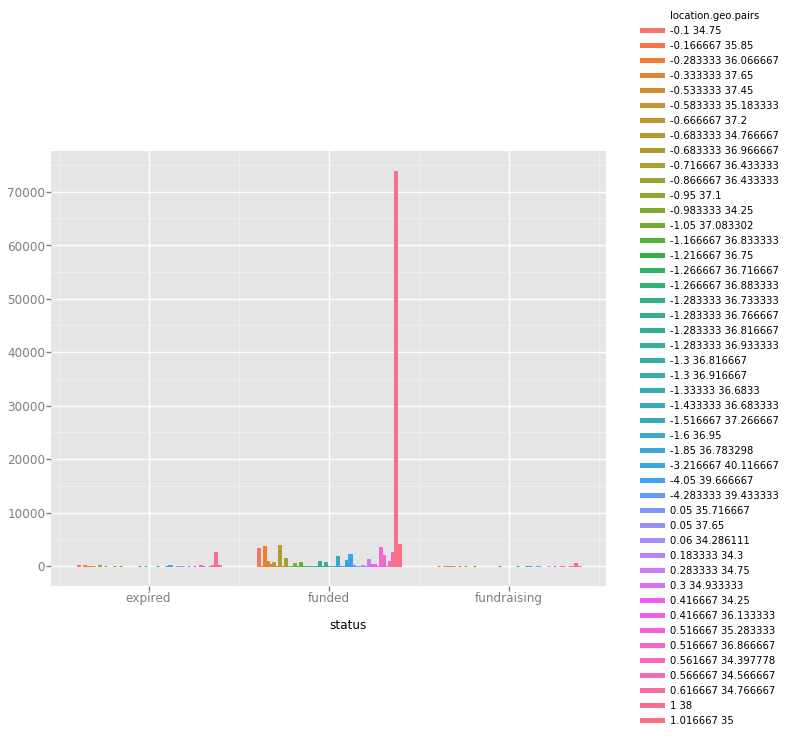

<ggplot: (69098567)>

1 38                   77254
1.016667 35             4396
-0.683333 34.766667     4025
-0.283333 36.066667     3975
0.516667 35.283333      3834
Name: location.geo.pairs, dtype: int64

In [62]:
ggplot(aes(x = 'status', fill = 'location.geo.pairs'), data = df) + geom_bar()
df['location.geo.pairs'].value_counts().head()

It looks like many loans are coming from a particular set of geo coordinates. Seems very strange, but perhaps it is possible. Let's take a look at another field location.town which has the name of the town where the loan is from which should help clarify.

In [63]:
df['location.town'].value_counts().head()

Likoni     5035
Kitale     4396
Kisii      4025
Nakuru     3975
Eldoret    3833
Name: location.town, dtype: int64

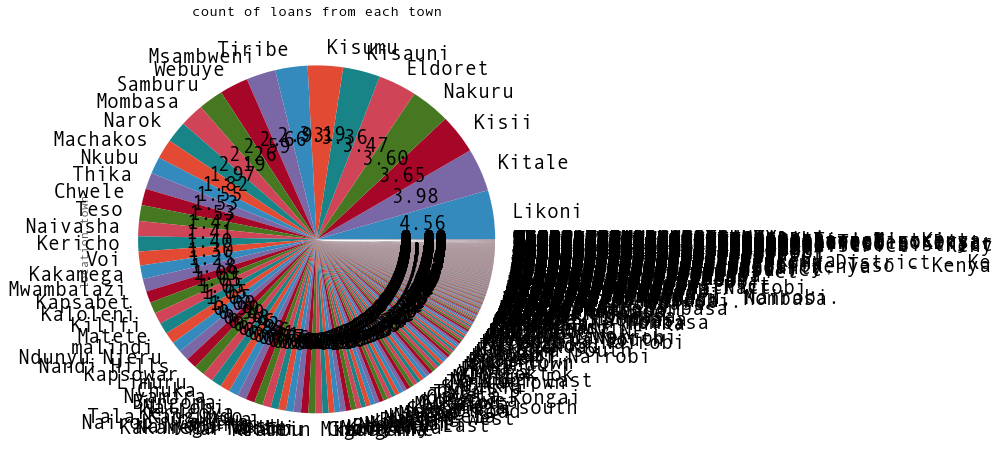

In [24]:
df['location.town'].value_counts().plot(kind='pie',title='count of loans from each town', autopct='%.2f', fontsize=20, figsize=(8, 8))                         


The messy chart above actually makes a lot more sense given what we would expect! It shows that loans disbursed across many different towns and are not concentrated in a single location. We now suspect there is a data issue with location.geo.pairs. We talk to our partners at Kiva and they confirm that this data field is problematic, we will not use it going forward and will instead use location.town.

### Exporting final dataset

Let's save our final dataframe!

In [25]:
df.to_csv(data_path+'/df.csv')